# Movie Recommender Systems - DreamStream (Part 2)
### Enhancing Movie Recommendations with Deep Learning

Benedikt Tremmel (60253)

Leonardo Heinemann (60384)

Maximilian Schön (50163)

Gilian Dustin Wagner (58029)

Malte Nicolas Haupt (58733)

# 1. Introduction

## 1.1 Overview and Business Case

DreamStream is an emerging streaming platform that offers a wide range of movies and TV shows to its users. While DreamStream has been successful in attracting new users, it faces a significant challenge in retaining them. The platform's user retention rate has been declining, primarily due to users' dissatisfaction with the movie recommendations provided. DreamStream's existing recommendation system, based on simple popularity metrics, fails to deliver personalized and relevant recommendations to its users. This lack of personalization leads to user frustration and disengagement, ultimately resulting in churn.


##### Short Recap

In Part 1 of this project, we focused on addressing DreamStream's user retention challenge by revamping their movie recommendation system using traditional machine learning techniques. We built models based on content-based filtering and collaborative filtering aiming to provide more personalized and relevant movie recommendations. Utilizing a dataset of 45,000 movies and 26 million ratings, our initial efforts helped improving recommendation accuracy. While the initial models provided a foundation, there remains a significant opportunity to leverage more sophisticated technologies to refine recommendation accuracy and personalization. This phase of the project aims to build on the power of deep learning to achieve these objectives, focusing on collaborative filtering and content-based approaches with neural networks.
    

##### Why Deep Learning?

While traditional machine learning techniques have laid a solid foundation for recommendation systems, they often fall short when it comes to handling complex user behaviors and large-scale data dynamically. Deep learning offers significant advancements in this area, primarily due to its ability to model intricate patterns and interactions within large datasets without extensive feature engineering. Neural networks, in particular, can learn to represent both users and items in a shared latent space, enhancing the system's ability to predict preferences accurately. With NLP techniques, deep learning can also extract valuable information from unstructured data like movie descriptions, enabling more context-aware recommendations. This capability is crucial for DreamStream as it strives to further enhance user engagement and reduce churn by making even more precise and contextually relevant recommendations.

##### Model Types

HIER BULLET POINT LISTE DER GENUTZEN MODELLE zur übersicht und warum welches model (mit bezug auf business case)

##### Objectives


BITTE ÄNDERN/ANPASSEN, DASS HIER IST NUR EIN VORSCHLAG

1. **Improve Recommendation Accuracy**: Develop deep learning models that can predict user preferences more accurately than traditional machine learning models.
2. **Leverage Unstructured Data**: Utilize NLP techniques to extract valuable information from unstructured data like movie descriptions to enhance recommendation relevance.
3. **Enhance Personalization**: Utilize neural networks to create more personalized recommendations based on user preferences and behavior.
4. **Scale Recommendation System**: Build models that can handle large-scale data dynamically and adapt to changing user preferences over time.


##### Part 2: Methodology and Approach

Part 2 of the project will build on the foundations laid in Part 1, with a primary focus on model development. We will follow the CRISP-DM methodology, but certain stages like exploratory data analysis (EDA) and initial data preparation will be skipped, as they were already covered in Part 1 (please see the appendix for reference).

These steps, however, remain critical for Part 2 of the project. Specifically, the EDA provides necessary groundwork for feature selection and offers initial insights into data quality, distribution, and potential biases. Part 2 leverages these insights, allowing us to focus on more complex aspects of model architecture and optimization without re-evaluating the foundational data characteristics. This continuity ensures efficiency and builds on our understanding of the dataset, enabling a more targeted approach in refining the recommendation algorithms with deep learning.

The original dataset of 45,000 movies and 26 million ratings can be found [here](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data). For Part 2, we will use a reduced subset (down to 3,000,000 ratings) of the preprocessed version of the dataset to reduce computational time.

Additional preprocessing steps tailored for deep learning applications will be implemented prior to model development. These will include critical tasks such as tokenization, normalization, and padding of text data to ensure compatibility with neural network architectures. We will also present the best models for both collaborative and content-based filtering from Part 1 and compare them with the deep learning models.
The primary metric utilized will be precision, which measures the proportion of relevant recommendations among the total recommendations made. This metric allows us to evaluate the models' ability to accurately predict user preferences and provide relevant movie recommendations. Additional metrics such as the RMSE will also be considered to provide a comprehensive evaluation of the models' performance.

## 1.2 Imports

The project will be implemented using Python and the following libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import scipy
import math
import datetime
import ast
import spacy
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

#### Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.3 Data Loading

### Stratified Sampling

We will use stratified sampling to downsample the ratings dataset to 100,000 entries. This will help us reduce the size of the dataset while maintaining the distribution of ratings. We will categorize the ratings into bins and sample an equal number of entries from each bin to ensure that the downsampled dataset is representative of the original dataset.


In [3]:
# transform pickle file to pandas dataframe
ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


In [5]:
# nr of entries in the dataset
ratings_df.shape

(24829828, 6)

In [6]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(100000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {strat_sampled_ratings_df.shape}")

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_25106/1716066896.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(


Original DF Shape: (24829828, 7)
Sampled DF Shape: (100000, 7)


We have successfully downsampled the ratings dataset to 100,000 entries using stratified sampling. We will now check the distribution of ratings in the original and downsampled datasets to ensure that the sampling process was successful.

In [7]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()
    
    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']
    
    return summary_stats

summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

,Original,Sampled
count,24829828.0,100000.0
mean,3.52898,3.52899
std,1.060177,1.060165
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


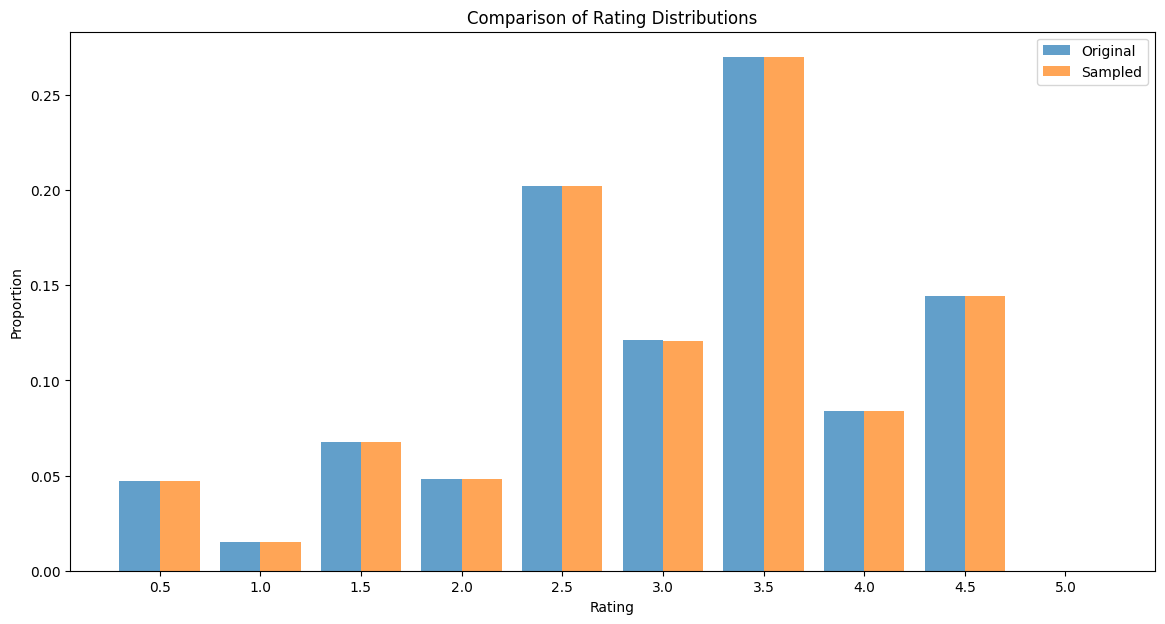

In [8]:
# Define your bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, strat_sampled_ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [9]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"
...,...,...,...,...,...,...,...
2596165,28184,2912,5.0,2000-11-21 00:08:40,3.588011,True,"[5.0, 5.5)"
2174721,23629,1185,5.0,1997-03-13 18:00:11,3.734463,True,"[5.0, 5.5)"
23363519,254448,49272,5.0,2016-08-08 15:59:55,3.819149,True,"[5.0, 5.5)"
19688576,214494,541,5.0,2005-04-05 14:26:59,3.395652,True,"[5.0, 5.5)"


The distribution of ratings in the downsampled dataset is similar to that of the original dataset, indicating that the stratified sampling process was successful. The downsampled dataset contains 100,000 entries and maintains the distribution of ratings across different categories.


We also did the Stratified Sampling for 1M and 3M datasets.

# 2 Content-Based-Recommendations

Content-based recommendation systems are an essential approach in the field of personalized recommendations. These systems generate suggestions that are closely aligned with user preferences by leveraging items' intrinsic attributes, such as movie descriptions, genres, cast, and metadata. Unlike collaborative filtering methods that rely on user interaction data, content-based recommendations can make relevant suggestions even for new items that do not have enough user reviews. This approach ensures more immediate and robust personalization, making it a critical strategy for providing accurate and meaningful movie recommendations.


# 2.1 Preprocessing

In [ ]:
df_merged = pd.read_pickle('/content/drive/My Drive/ML Group/df_merged_cleaned.pkl')
df_ratings = pd.read_pickle('/content/drive/My Drive/ML Group/df_ratings_100k.pkl')

### Inspecting the movies dataset regarding languages

Filtering df_merged to only include movies that are english. This ensures that the text data aligns with the language the model was trained on, which is crucial for the effectiveness of the embeddings generated by BERT.

In [5]:
df_merged = df_merged[df_merged['original_language'] == 'en']

In [6]:
df_merged

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]
...,...,...,...,...,...,...,...,...,...,...,...,...
46749,176263,0,en,It's the year 3000 AD. The world's most danger...,1995-01-01,85.0,Caged Heat 3000,"[Lisa Boyle, Kena Land, Zaneta Polard, Don Yan...",[(none)],[Science Fiction],[Concorde-New Horizons],[United States of America]
46750,176267,0,en,"Yet another version of the classic epic, with ...",1991-05-13,104.0,Robin Hood,"[Patrick Bergin, Uma Thurman, David Morrissey,...",[(none)],"[Drama, Action, Romance]","[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State..."
46753,176273,0,en,"When one of her hits goes wrong, a professiona...",2003-08-01,90.0,Betrayal,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",[(none)],"[Action, Drama, Thriller]",[American World Pictures],[United States of America]
46754,176275,0,en,"In a small town live two brothers, one a minis...",1917-10-21,87.0,Satan Triumphant,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",[(none)],[(none)],[Yermoliev],[Russia]


## 2.1.1 List Columns

To improve the quality of our dataset and prepare it for advanced text-based modeling, we will thoroughly clean four key columns: genre_extracted, actors, keywords_extracted, and production_company_extracted. This process entails standardizing the text by removing placeholders, lowercasing all entries, and filtering out non-alphabetical characters to ensure consistency across text fields.

### Inspection for placeholders

In [7]:
placeholder_counts = df_merged['keywords_extracted'].apply(lambda x: str(x).strip().lower() == "['(none)']").value_counts()

print("Occurrences of '[(none)]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[(none)]': 7478
Occurrences of other values or variations: 22278


In [8]:
placeholder_counts = df_merged['genre_extracted'].apply(lambda x: str(x).strip().lower() == "['(none)']").value_counts()

print("Occurrences of '[(none)]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[(none)]': 1110
Occurrences of other values or variations: 28646


In [9]:
placeholder_counts = df_merged['production_company_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7165
Occurrences of other values or variations: 22591


In [10]:
placeholder_counts = df_merged['actors'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1280
Occurrences of other values or variations: 28476


### Cleaning Function

The clean_list_data function is intended to clean lists by removing placeholder entries. It first determines whether the list is empty, and if not, it removes any of the placeholder entries. The function is then applied to several columns in the DataFrame df_merged, specifically the 'genre_extracted', 'actors', 'keywords_extracted', and 'production_company_extracted' columns, to ensure that they only contain meaningful data by removing any placeholder values.

In [11]:
# Define a function to clean placeholders in lists
def clean_list_data(data):
    if not data:  # Checks if the list is empty
        return []
    # Remove any placeholder entries
    return [item for item in data if item.lower() not in ['(none)', 'none', 'n/a', 'null', 'unknown']]

# Apply the cleaning function to each column
df_merged['genre_extracted'] = df_merged['genre_extracted'].apply(clean_list_data)
df_merged['actors'] = df_merged['actors'].apply(clean_list_data)
df_merged['keywords_extracted'] = df_merged['keywords_extracted'].apply(clean_list_data)
df_merged['production_company_extracted'] = df_merged['production_company_extracted'].apply(clean_list_data)

### Verification of cleaning

In [12]:
placeholder_counts = df_merged['keywords_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7478
Occurrences of other values or variations: 22278


In [13]:
placeholder_counts = df_merged['genre_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1110
Occurrences of other values or variations: 28646


In [14]:
placeholder_counts = df_merged['production_company_extracted'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 7165
Occurrences of other values or variations: 22591


In [15]:
placeholder_counts = df_merged['actors'].apply(lambda x: str(x).strip().lower() == "[]").value_counts()

print("Occurrences of '[]':", placeholder_counts.get(True, 0))
print("Occurrences of other values or variations:", placeholder_counts.get(False, 0))

Occurrences of '[]': 1280
Occurrences of other values or variations: 28476


After applying the cleaning function to the 'genre_extracted', 'actors', 'keywords_extracted', and 'production_company_extracted' columns in the DataFrame df_merged, placeholders have successfully been standardized to [] for the inspected columns.

### Standardize Case and Remove Special Characters

This is essential to maintain consistency and reduce the vocabulary size that the model needs to understand.

In [16]:
# Function to clean individual strings in lists
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    return text.strip()

# Function to process lists of strings
def preprocess_list(data):
    return [clean_text(item) for item in data if item]

In [17]:
# Apply preprocessing to each column
df_merged['genre_extracted'] = df_merged['genre_extracted'].apply(preprocess_list)
df_merged['actors'] = df_merged['actors'].apply(preprocess_list)
df_merged['keywords_extracted'] = df_merged['keywords_extracted'].apply(preprocess_list)
df_merged['production_company_extracted'] = df_merged['production_company_extracted'].apply(preprocess_list)

## 2.1.2 'Overview' Column

In the following sections, we will thoroughly analyze and clean the "Overview" column, which contains detailed descriptions of movies that are critical to generate meaningful content-based recommendations

In [18]:
df_merged["overview"].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [19]:
# Number of total values
total_entries = len(df_merged['overview'])
print(f"Total entries: {total_entries}")

# Number of missing values
missing_values = df_merged['overview'].isnull().sum()
print(f"Missing values: {missing_values}")

# Number of unique values
unique_values = df_merged['overview'].nunique()
print(f"Unique values: {unique_values}")

# Average length of movie descriptions
average_length = df_merged['overview'].dropna().apply(len).mean()
print(f"Average Length of Descriptions: {average_length:.2f} characters")

# Shortest length of movie descriptions
shortest_length = df_merged['overview'].dropna().apply(len).min()
print(f"Shortest Length of Descriptions: {shortest_length:.2f} characters")

# Longest length of movie descriptions
longest_length = df_merged['overview'].dropna().apply(len).max()
print(f"Longest Length of Descriptions: {longest_length:.2f} characters")

Total entries: 29756
Missing values: 0
Unique values: 29690
Average Length of Descriptions: 313.33 characters
Shortest Length of Descriptions: 1.00 characters
Longest Length of Descriptions: 1000.00 characters


After examining the entries in the df_merged DataFrame with 1000-character descriptions, We are decided to keep them. These descriptions are complete and informative, despite reaching the character limit. They are fully usable and add value to our analysis. Consequently, we will continue to include these long descriptions to ensure the dataset remains robust and comprehensive.

Identify entries where descriptions are extremely short. These might be errors or insufficient descriptions.

In [20]:
short_descriptions_mask = df_merged['overview'].dropna().apply(len) < 30

# Filter the original DataFrame to show only rows with short descriptions
short_desc_df = df_merged[short_descriptions_mask]

# Display these descriptions to assess their relevance
short_desc_df.head(10)

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
987,1001,0,en,No overview found.,1979-08-22,94.0,L'associé,"[michel serrault, claudine auger, catherine al...",[],[comedy],[],[]
1633,1692,0,en,No overview found.,1996-01-01,85.0,Alien Escape,"[gail harris, bernie van de yacht, heather for...","[female nudity, mutant, cabin, alien lifeform,...","[horror, science fiction]",[],[United States of America]
2250,2343,0,en,No overview found.,1998-08-02,98.0,The Naked Man,"[michael rapaport, michael jeter, rachael leig...","[male nudity, double life, wrestling, murder, ...","[comedy, thriller]",[],[United States of America]
3788,3887,0,en,No overview found.,1998-01-01,94.0,Went to Coney Island on a Mission from God... ...,[],[independent film],[drama],[],[]
4573,4667,0,en,,1989-03-18,124.0,Slaves of New York,"[bernadette peters, chris sarandon, mary beth ...",[],[drama],[],[United States of America]
7382,7566,1,en,No overview found.,1984-11-20,136.0,28 Up,[],[],"[documentary, foreign]",[],[United Kingdom]
9262,27215,0,en,No overview found.,2000-08-18,103.0,Badding,"[janne reinikainen, karoliina blackburn, peter...",[],[],[],[Finland]
9986,32659,0,en,No overview found.,2001-11-21,108.0,Tanguy,"[eric berger, sabine azma, andr dussollier, hl...","[paris, china, parent child relationship, flat...",[comedy],"[les productions du champ poirier, tps cinma, ...",[France]
11371,48167,0,en,No overview found.,2004-01-29,92.0,Aaltra,"[benot delpine, gustave de kervern, michel de ...","[belgium, wheelchair user, lovehate relationsh...","[comedy, foreign, drama]",[la parti productions],[France]
11679,51014,0,en,No overview found.,1968-01-07,120.0,The Strange Case of Dr. Jekyll and Mr. Hyde,"[jack palance, denholm elliott, leo genn, tori...","[london england, double life, jekyll and hyde]","[drama, science fiction, thriller]",[],"[Canada, United States of America]"


Identified entries: No overview found, blank, ..., Not Available, No Overview, x, no overview yet,

In [21]:
# Create a list with unwanted movie descriptions
unwanted_strings = ['No overview found.', '', '...', 'Not Available', 'No Overview', 'x', 'no overview yet', "No overview"]

# Strip leading and trailing spaces and filter out rows with unwanted strings and ensure length is at least 10 characters
df_merged['overview'] = df_merged['overview'].str.strip()
df_merged = df_merged[~df_merged['overview'].isin(unwanted_strings) & (df_merged['overview'] != '') & (df_merged['overview'].str.len() >= 10)]

# Check the updated DataFrame
print("Total entries after cleaning:", df_merged.shape[0])

Total entries after cleaning: 29697


In [22]:
# Find duplicates in the 'overview' column
duplicates = df_merged['overview'].duplicated(keep=False)

# Filter the DataFrame to show only the duplicated overviews
duplicated_overviews = df_merged[duplicates]

# Display the head of the duplicated overviews
print(duplicated_overviews[['overview', "release_date"]].head(10))

                                                overview release_date
2048   Wilbur the pig is scared of the end of the sea...   1973-03-01
2397   With friends like these, who needs enemies? Th...   1999-02-05
2985   Director Michael Apted revisits the same group...   1998-07-28
4705   Adventurer Allan Quartermain leads an expediti...   1937-01-01
7080   Nick Carraway, a young Midwesterner now living...   1974-03-27
8537   Adventurer Allan Quartermain leads an expediti...   1950-11-09
9024   Director Michael Apted revisits the same group...   1991-08-29
11539  Wilbur the pig is scared of the end of the sea...   2006-12-15
14547  Miser Ebenezer Scrooge is awakened on Christma...   2009-11-04
16855  Mary, a writer working on a novel about a love...   1941-08-29


Duplicates are due to the fact that movies of the same series are featured in the dataset.

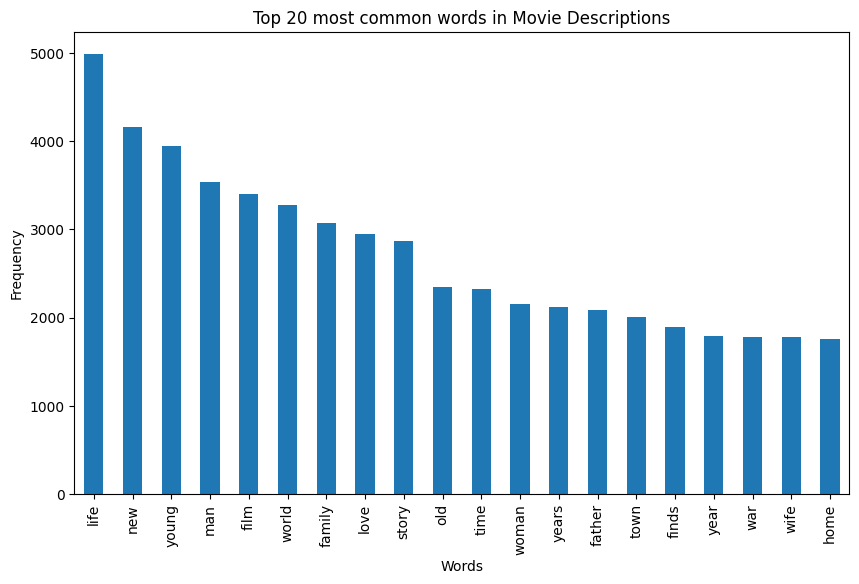

In [23]:
# Create a vectorizer instance to count frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_merged['overview'].dropna())

# Convert X to a DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_words.plot(kind='bar')
plt.title('Top 20 most common words in Movie Descriptions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

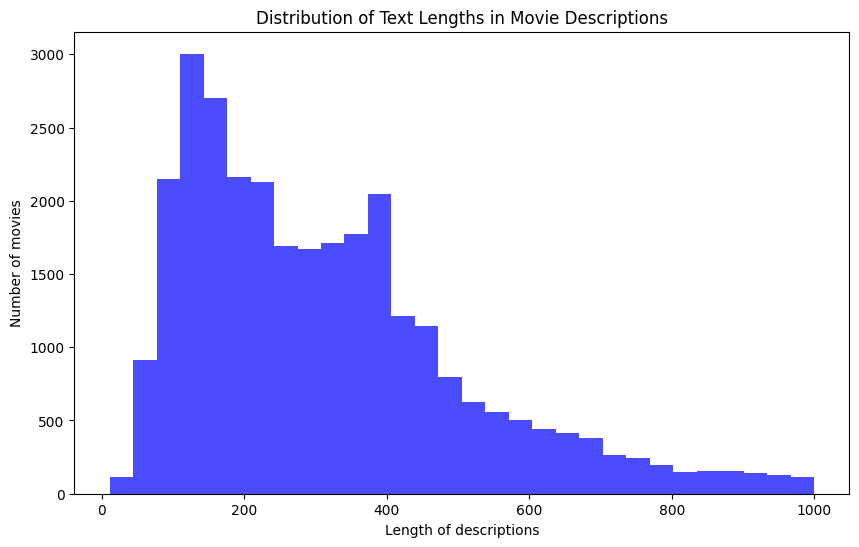

In [24]:
# Calculate text lengths
text_lengths = df_merged['overview'].dropna().apply(len)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in Movie Descriptions')
plt.xlabel('Length of descriptions')
plt.ylabel('Number of movies')
plt.show()

Interpretation
- From the graph, it's evident that the distribution is right-skewed, with a majority of descriptions being between roughly 100 and 400 characters long. There are fewer very short descriptions (near 0 characters) and the number of descriptions decreases steadily as the length increases, with very few descriptions reaching up to 1000 characters.
- Significant number of between 100-300 Characters: Most descriptions are concise, providing brief information about the movie, which is typical for summaries intended to give a quick overview without going into detail.
- Few Long Descriptions: The sharp decline in frequency as description length increases suggests that longer descriptions are uncommon. These might be detailed synopses rather than simple overviews.
- Very Short Descriptions: The relatively low number of extremely short descriptions (near 0 characters) is good as these might not provide useful information.

Considerations for NLP Recommender System based on Similarity Score

- The prevalence of shorter texts facilitates standardized embedding processes, reducing the complexity of handling variable text lengths. Descriptions within the 100-300 character range provide enough detail for effective similarity analysis, allowing accurate recommendations based on narrative elements.
- Vector Representation of Texts:
Texts need to be converted into numerical representations (e.g., TF-IDF or Word2Vec embeddings) for similarity comparison. The effectiveness of these representations can vary with text length.
Short descriptions may not provide enough context for accurate similarity scoring, while very long descriptions might introduce too much noise or irrelevant information.
- We'll continuously refine our handling of text lengths based on system performance to balance detail richness with computational demands.

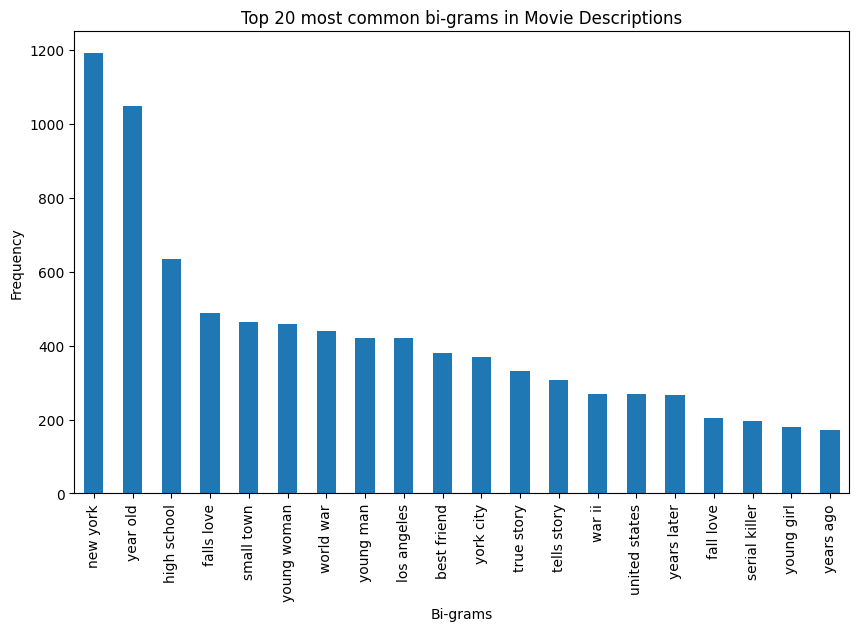

In [25]:
# Bi-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_matrix = bigram_vectorizer.fit_transform(df_merged['overview'].dropna())

# Sum up the counts of each bi-gram and sort
bigrams = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out())
common_bigrams = bigrams.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_bigrams.plot(kind='bar')
plt.title('Top 20 most common bi-grams in Movie Descriptions')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Potentially checking for and removing noise like HTML tags, excessive symbols, etc.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    return text

# Apply cleaning function
cleaned_overviews = df_merged['overview'].apply(clean_text)

In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29697 entries, 0 to 46755
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   movieId                       29697 non-null  Int64         
 1   belongs_to_collection         29697 non-null  int64         
 2   original_language             29697 non-null  object        
 3   overview                      29697 non-null  object        
 4   release_date                  29697 non-null  datetime64[ns]
 5   runtime                       29697 non-null  float64       
 6   title                         29697 non-null  object        
 7   actors                        29697 non-null  object        
 8   keywords_extracted            29697 non-null  object        
 9   genre_extracted               29697 non-null  object        
 10  production_company_extracted  29697 non-null  object        
 11  production_country_extracted  296

Define the clean_text function to standardize the movie descriptions by converting all text to lowercase, removing HTML tags and special characters. Finally apply this function to the 'overview' column of my df_merged DataFrame to prepare the data for further analysis.

In [28]:
def clean_text(text):
    if not pd.isna(text):
        # Convert text to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    return text

In [29]:
# Apply the cleaning function to the 'overview' column
df_merged['overview'] = df_merged['overview'].apply(clean_text)

##Inspect the column

In [30]:
pd.set_option('display.max_colwidth', None)
df_merged["overview"].head(10)

0                                                                                                                                                   led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene afraid of losing his place in andys heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences
1                                                           when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan  an adult whos been trapped inside the game for  years  into their living room alans only hope for freedom is to finish the game which proves risky as all three find themselves running from giant rhinoceroses evil monkeys and other terrifying creatures
2                                                                                                                 

In [31]:
# Inspect any row of the overview column
print(df_merged['overview'].iloc[[10, 50, 100]])

10                                                                                                                                                 widowed us president andrew shepherd one of the worlds most powerful men can have anything he wants  and what he covets most is sydney ellen wade a washington lobbyist but shepherds attempts at courting her spark wild rumors and decimate his approval ratings
54     sadie looks up to her older sister georgia a successful folk singer whos happily married with children but cant break out of the barband circuit and hit the big time she desperately covets its in part due to her attraction to drugs and booze and also to her own unwise choice in men finally though sadies achilles heel is a rough unlovely voice very different than her sisters crowdpleasing singing
113                                    francis the boss of a small plumbing supply company is harassed by tax collectors striking employees and an impossible wife and daughter his only joy

# 2.2 Feature Engineering

Next, we focus on the critical task of feature engineering, which involves transforming raw data into meaningful features that improve the performance of our content-based recommendation models. We hope to capture the movies' essential characteristics by carefully selecting and creating features such as 'combined_text'. These engineered features serve as the foundation for developing robust recommender systems.

### Textual Feature - Combined Text

After thoughtfully cleaning the different text columns of the dataset that might be relevant to give content-based reocmmendations we want to combine them into a single feature column. The combined_text feature aggregates critical textual metadata from genres, actors, keywords, and movie descriptions into a single comprehensive descriptor for each movie. This aggregation captures the essence of a movie’s content, thematic elements, and appeal, which is crucial for content-based filtering. By synthesizing this information, the recommender system can identify and suggest movies with similar thematic and content attributes, enhancing personalization and user engagement.

In [32]:
# Define a function to join non-empty items
def join_non_empty(items):
    # Filter out empty lists and join non-empty strings with a space
    return ' '.join([item for item in items if item])

# Apply the function to each row in df_merged to create the combined_text column
df_merged['combined_text'] = df_merged.apply(lambda row: join_non_empty([
    ' '.join(row['genre_extracted']),
    ' '.join(row['actors']),
    ' '.join(row['keywords_extracted']),
    ' '.join(row['production_company_extracted']),
    row['overview']
]), axis=1)

### Weighted Score

The weighted_score feature adds a movie's average rating to the number of ratings it has received, ensuring that movies with a large number of ratings are given appropriate weight. This score reduces the bias toward movies with fewer ratings, which may have artificially high scores. The weighted_score is a more balanced and reliable measure of a film's popularity and quality because it takes into account both the quality and quantity of ratings. This feature is useful for advanced content-based modeling because it improves the accuracy and robustness of recommendations by prioritizing highly rated and frequently rated movies, resulting in more trustworthy and relevant suggestions for users.

In [33]:
movie_stats = df_ratings.groupby('movieId').agg(average_rating=('rating', 'mean'), rating_count=('rating', 'count')).reset_index()

C = movie_stats['average_rating'].mean()
m = movie_stats['rating_count'].quantile(0.90)

def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

movie_stats['weighted_score'] = movie_stats.apply(weighted_rating, axis=1)

df_ratings = df_ratings.merge(movie_stats[['movieId', 'weighted_score']], on='movieId', how='left')

df_ratings = df_ratings.merge(movie_stats[['movieId', 'average_rating', 'rating_count']], on='movieId', how='left')

print(df_ratings.head())

   userId  movieId  rating           timestamp  user_mean_rating  \
0  128365     1037     0.5 2009-10-19 10:10:37          3.104895   
1   34770    27316     0.5 2006-06-10 09:14:33          1.329146   
2  108700      307     0.5 2010-05-12 21:26:12          3.729651   
3  162680    73929     0.5 2015-11-22 18:22:29          3.505618   
4  141941     4308     0.5 2006-06-10 05:21:47          2.987685   

   liked_by_user rating_category  weighted_score  average_rating  rating_count  
0          False      [0.5, 1.0)        2.987271            2.75            32  
1          False      [0.5, 1.0)        3.205775            2.25             2  
2          False      [0.5, 1.0)        3.593367            3.92            25  
3          False      [0.5, 1.0)        3.176359             0.5             1  
4          False      [0.5, 1.0)        3.444903        3.516667            60  


### Movie Age

The movie_age feature calculates the number of years since a movie's release by subtracting the current year from the release year. This feature is important for advanced content-based modeling because it allows the recommender system to consider a movie's age, which can influence user preferences. Incorporating movie_age allows the model to distinguish between classic films and new releases, allowing it to make more nuanced and personalized recommendations by taking into account how users' interests may differ depending on the age of the films.

In [34]:
current_year = datetime.datetime.now().year

df_merged['movie_age'] = current_year - pd.to_datetime(df_merged['release_date']).dt.year

### Sentiment Analysis Overview

The sentiment_polarity feature represents the sentiment score of a movie overview, which is calculated using the TextBlob library to determine the polarity of the text. This feature is useful for advanced content-based modeling because it quantifies the emotional tone of a movie's description, providing information about whether it is perceived as positive, negative, or neutral. By incorporating sentiment_polarity, the recommender system can better align recommendations with users' emotional preferences and sentiments, increasing the relevancy and personalization of suggestions.


In [35]:
def get_sentiment(text):
    try:
        return float(TextBlob(text).sentiment.polarity)
    except Exception as e:
        print(f"Error processing text: {e}")
        return float('nan')

df_merged['sentiment_polarity'] = df_merged['overview'].apply(get_sentiment)

In [36]:
print("Number of NaN values in 'sentiment_polarity' after conversion:", df_merged['sentiment_polarity'].isna().sum())

Number of NaN values in 'sentiment_polarity' after conversion: 0


Adding engineered features to df_grouped

 #### Combining df_ratings and df_merged

In [37]:
df_combined = pd.merge(df_ratings, df_merged, on='movieId', how='inner')

#### Rating Threshold

Setting a rating threshold of 20 ensures that only movies with a large number of ratings are included in the dataset for modeling. This makes sense because movies with few ratings may have unreliable or skewed average ratings, reducing the accuracy of the recommendation system. By excluding movies with fewer than 20 ratings, the model focuses on films with more consistent and representative user feedback, resulting in more reliable and robust recommendations. This threshold helps to maintain the dataset's quality and reliability, which improves the overall performance of content-based modeling.

In [38]:
ratings_per_movie = df_combined.groupby('movieId').size()

movies_with_enough_ratings = ratings_per_movie[ratings_per_movie >= 20].index

df_item_modeling = df_combined[df_combined['movieId'].isin(movies_with_enough_ratings)]

print(f"Original dataset size: {df_combined.shape}")
print(f"Filtered dataset size: {df_item_modeling.shape}")

Original dataset size: (93810, 24)
Filtered dataset size: (65766, 24)


#### Grouping Movies

We are configuring the modeling DataFrame, df_grouped, which contains the engineered features. This DataFrame aggregates data by movieId, keeping the first occurrence of the title and combined text and calculating the mean values for weighted_score, movie_age, and sentiment_polarity. This aggregation ensures that each movie is represented by its key features, allowing for advanced content-based modeling.

In [39]:
df_grouped = df_item_modeling.groupby('movieId', as_index=False).agg({
    'title': 'first',
    'combined_text': 'first',
    'weighted_score': 'mean',
    'movie_age': 'mean',
    'sentiment_polarity': 'mean'
})

df_grouped.head()

,movieId,title,combined_text,weighted_score,movie_age,sentiment_polarity
0,1,Toy Story,animation comedy family tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r lee ermey sarah freeman penn jillette jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life pixar animation studios led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the scene afraid of losing his place in andys heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences,3.808411,29.0,0.112121
1,2,Jumanji,adventure fantasy family robin williams jonathan hyde kirsten dunst bradley pierce bonnie hunt bebe neuwirth david alan grier patricia clarkson adam hannbyrd laura bell bundy james handy gillian barber brandon obray cyrus thiedeke gary joseph thorup leonard zola lloyd berry malcolm stewart annabel kershaw darryl henriques robyn driscoll peter bryant sarah gilson florica vlad june lion brenda lockmuller board game disappearance based on childrens book new home recluse giant insect tristar pictures teitler film interscope communications when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan an adult whos been trapped inside the game for years into their living room alans only hope for freedom is to finish the game which proves risky as all three find themselves running from giant rhinoceroses evil monkeys and other terrifying creatures,3.299728,29.0,-0.218750
2,3,Grumpier Old Men,romance comedy walter matthau jack lemmon annmargret sophia loren daryl hannah burgess meredith kevin pollak fishing best friend duringcreditsstinger old men warner bros lancaster gate a family wedding reignites the ancient feud between nextdoor neighbors and fishing buddies john and max meanwhile a sultry italian divorce opens a restaurant at the local bait shop alarming the locals who worry shell scare the fish away but shes less interested in seafood than she is in cooking up a hot time with max,3.289113,29.0,0.038889
3,5,Father of the Bride Part II,comedy steve martin diane keaton martin short kimberly williamspaisley george newbern kieran culkin bd wong peter michael goetz kate mcgregorstewart jane adams eugene levy lori alan baby midlife crisis confidence aging daughter mother daughter relationship pregnancy contraception gynecologist sandollar productions touchstone pictures just when george banks has recovered from his daughters wedding he receives the news that shes pregnant and that georges wife nina is expecting too he was planning on selling their home but thats a plan that like george will have to change with the arrival of both a grandchild and a kid of his own,3.208483,29.0,0.466667
4,6,Heat,action crime drama thriller al pacino robert de niro val kilmer jon voight tom sizemore diane venora amy brenneman ashley judd mykelti williamson natalie portman ted levine tom noonan tone loc hank azaria wes studi dennis haysbert danny trejo henry rollins william fichtner kevin gage susan traylor jerry trimble ricky harris jeremy piven xander berkeley begonya plaza rick avery hazelle goodman ray buktenica max daniels vince deadrick jr steven ford farrah forke patricia healy paul herman cindy katz brian libby dan martin mario roberts thomas rosales jr yvonne zima mick gould bud cort viviane vives kim staunton martin ferrero brad baldridge andrew camuccio kenny endoso kimberly flynn niki harris bill mcintosh rick marzan terry miller daniel ohaco kai soremekun peter blackwell trevor coppola mary kircher darin mangan robert miranda manny perry iva franks singer tim werner philip ettington robbery detective bank obsession chase shooting thief honor murder suspense heist betrayal money gang cat and mouse criminal mastermind cult film excon heist movie one last job loner bank jo

# 2.3 Modeling

In this section, we will configure and test various content-based recommender systems using advanced techniques. These include TFIDF for term frequency analysis, Word2Vec for capturing semantic relationships between words, and BERT Foundation Models for deep contextual understanding. Each technique will feature both baseline and advanced models. The baseline models will only consider cosine similarity to establish a benchmark for each technique, whereas the advanced models will include additional features to improve the relevance of our movie recommendations, leveraging the engineered features we have prepared.


## 2.3.1 TFIDF Content Recommendations

To start off, we will use TFIDF (Term Frequency-Inverse Document Frequency) analysis to build content-based recommendation systems. This technique, which assesses the importance of words in documents in comparison to a collection of documents, was previously used in the part 1 of the project. We will summarize it here to establish a performance benchmark for future comparison with new models. TFIDF allows us to recommend similar movies based on textual content because it captures the relevance of terms within movie descriptions. We will create both baseline and advanced models, with the baseline model using cosine similarity to benchmark the technique and the advanced model adding additional features to improve recommendation relevance capturing more complex relationships and nuances within the data.







### TFIDF Baseline Model

In [40]:
class BaselineContentRecommenderTFIDF:
    def __init__(self, movies_df, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(df_grouped['combined_text'])
        self.similarity_matrix = cosine_similarity(self.tfidf_matrix)

    def recommend(self, movie_id, top_n=10):
        movie_id = str(movie_id)
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [41]:
recommender_baseTFIDF = BaselineContentRecommenderTFIDF(df_grouped, k=100)
recommendations_baseTFIDF = recommender_baseTFIDF.recommend('1', top_n=10)
print(recommendations_baseTFIDF[['movieId', 'title', 'cosine_similarity']])

     movieId                       title  cosine_similarity
720     3114                 Toy Story 2           0.457090
1147   78499                 Toy Story 3           0.381763
28        60  The Indian in the Cupboard           0.113025
674     2797                         Big           0.108510
307     1103       Rebel Without a Cause           0.107731
887     4886              Monsters, Inc.           0.098461
199      596                   Pinocchio           0.094334
1130   68954                          Up           0.087531
591     2355                A Bug's Life           0.084093
1176   95441                         Ted           0.082772


In [42]:
recommendations_baseTFIDF = recommender_baseTFIDF.recommend('2', top_n=10)
print(recommendations_baseTFIDF[['movieId', 'title', 'cosine_similarity']])

     movieId                                                           title  \
637     2600                                                        eXistenZ   
561     2161                                           The NeverEnding Story   
905     5266                                                      Panic Room   
546     2105                                                            Tron   
1180   97913                                                  Wreck-It Ralph   
1048   41566  The Chronicles of Narnia: The Lion, the Witch and the Wardrobe   
1075   49272                                                   Casino Royale   
719     3108                                                 The Fisher King   
1009    8957                                                             Saw   
791     3698                                                 The Running Man   

      cosine_similarity  
637            0.122969  
561            0.108911  
905            0.102681  
546            

### TFIDF Advanced Model

We will now include additional features for the advanced model. These features are weighted_score, sentiment_polarity, and movie_age, and they will be combined with the cosine similarity score to improve the overall recommendation.

In [43]:
class AdvancedContentRecommenderTFIDF:
    def __init__(self, movies_df, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.k = k
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.movies_df['combined_text'])
        self.similarity_matrix = cosine_similarity(self.tfidf_matrix)

    def recommend(self, movie_id, top_n=10):
        movie_id = str(movie_id)
        if movie_id not in self.movies_df['movieId'].values:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return pd.DataFrame()

        movie_index = self.movies_df.index[self.movies_df['movieId'] == movie_id].tolist()[0]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
            0.5 * top_k_df['cosine_similarity'] +
            0.2 * top_k_df['weighted_score'] +
            0.3 * top_k_df['sentiment_polarity'] +
            0.1 * top_k_df['movie_age']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score']]

In [44]:
recommender_advanced_tfidf = AdvancedContentRecommenderTFIDF(df_grouped, k=100)
recommendations_advanced_tfidf = recommender_advanced_tfidf.recommend('1', top_n=10)
print(recommendations_advanced_tfidf[['movieId', 'title', 'combined_score']])

     movieId              title  combined_score
720     3114        Toy Story 2        0.494856
343     1235   Harold and Maude        0.348563
538     2078    The Jungle Book        0.322128
591     2355       A Bug's Life        0.318722
276     1028       Mary Poppins        0.310332
340     1230         Annie Hall        0.308001
527     2018              Bambi        0.302490
1147   78499        Toy Story 3        0.296122
1005    8910  I Heart Huckabees        0.292712
346     1244          Manhattan        0.292305


## 2.3.2 Word2Vec Content Recommendations

In this section, we'll use Word2Vec, a neural network-based technique that converts words' semantic relationships into continuous vector representations, to build content-based recommender systems. This method enables us to comprehend and represent the contextual meaning of words in movie descriptions, allowing for more sophisticated and meaningful comparisons between films.

### Importing Google Word2Vec Model

We are choosing to import Google's pre-trained Word2Vec model primarily because of its extensive training on a large Google News dataset, which includes a rich and diverse vocabulary from multiple domains, ensuring comprehensive coverage and nuanced understanding of language. This model, which has already been trained, saves significant time and computational resources that would otherwise be required to train a model from scratch. It provides high-quality word embeddings that capture complex semantic relationships between words, allowing for the creation of more advanced, contextually aware recommendation systems. Furthermore, the pre-trained model has the potential to improve generalization capabilities across various textual data, increasing the accuracy and relevance of recommendations without the need for extensive domain-specific data for training. This makes it an effective choice for quickly integrating advanced NLP features into applications, particularly when working with limited resources like we are during this project.

In [45]:
"""
import gensim.downloader as api

# Load the model
word2vec_model = api.load('word2vec-google-news-300')

# Save the model to Drive
word2vec_model.save('/content/drive/My Drive/ML Group/word2vec-google-news-300.model')
"""


"\nimport gensim.downloader as api\n\n# Load the model\nword2vec_model = api.load('word2vec-google-news-300')\n\n# Save the model to Drive\nword2vec_model.save('/content/drive/My Drive/ML Group/word2vec-google-news-300.model')\n"

In [46]:
# Load the model from Google Drive
word2vec_model = KeyedVectors.load('/content/drive/My Drive/ML Group/word2vec-google-news-300.model', mmap='r')

### Baseline Word2Vec

The Baseline Word2Vec model sets a performance benchmark by focusing solely on the cosine similarity of movie descriptions. Using the Word2Vec model to convert textual data into continuous vector representations, semantic relationships between words are captured. This method allows us to compare the similarity of movies based on their textual features, providing a fundamental benchmark for evaluating more sophisticated models.

In [47]:
class BaselineContentRecommenderWord2Vec:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        # Tokenize the document and take the average of the word vectors
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [48]:
recommender_base_word2vec = BaselineContentRecommenderWord2Vec(df_grouped, word2vec_model)
recommendations_base_word2vec = recommender_base_word2vec.recommend('1', top_n=10)
print(recommendations_base_word2vec[['movieId', 'title', 'cosine_similarity']])

     movieId                 title  cosine_similarity
720     3114           Toy Story 2           0.916175
1133   69757  (500) Days of Summer           0.904147
49       158                Casper           0.903566
406     1380                Grease           0.902637
674     2797                   Big           0.902566
...      ...                   ...                ...
1180   97913        Wreck-It Ralph           0.875085
263      933      To Catch a Thief           0.874960
250      909         The Apartment           0.874792
305     1100       Days of Thunder           0.874344
625     2490               Payback           0.874319

[100 rows x 3 columns]


### Advanced Word2Vec

Similar to the logic used in the TFIDF advanced model, the Advanced Word2Vec model includes additional features to improve recommendation relevance. In addition to cosine similarity between Word2Vec embeddings, this model incorporates key features such as weighted_score, sentiment_polarity, and movie_age. By combining these factors, the Advanced Word2Vec method captures more complex relationships and nuances, resulting in more sophisticated movie recommendations.

In [49]:
class AdvancedContentRecommenderWord2Vec:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

         # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
          print(f"Movie ID {movie_id} not found in the dataset.")
          return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
          0.5 * top_k_df['cosine_similarity'] +
          0.2 * top_k_df['weighted_score'] +
          0.2 * top_k_df['sentiment_polarity'] +
          0.1 * top_k_df['movie_age']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [50]:
recommender_advanced_word2vec = AdvancedContentRecommenderWord2Vec(df_grouped, word2vec_model)
recommendations_advanced_word2vec = recommender_advanced_word2vec.recommend('1', top_n=10)
print(recommendations_advanced_word2vec[['movieId', 'title', 'combined_score']])

    movieId                                title  combined_score
813    3911                         Best in Show        0.727264
276    1028                         Mary Poppins        0.709346
248     905                It Happened One Night        0.707435
542    2087                            Peter Pan        0.695356
720    3114                          Toy Story 2        0.690020
245     902               Breakfast at Tiffany's        0.675651
364    1269                 Arsenic and Old Lace        0.674261
290    1073  Willy Wonka & the Chocolate Factory        0.670177
250     909                        The Apartment        0.669026
326    1207                To Kill a Mockingbird        0.660063


## 2.3.3 BERT-Based Content Recommendations



This section will show how to build content-based recommender systems with BERT (Bidirectional Encoder Representations from Transformers) models. BERT models provide deep contextual understanding by capturing the nuances of word relationships in the text. Using BERT, we hope to generate high-quality embeddings that reflect the semantic content of movie descriptions. These models are very large pretrained models built on the transformer architecture and are well-known for their superior performance in natural language understanding tasks. The BERT model family includes a number of variants that have been fine-tuned for specific natural language processing tasks, providing tailored solutions for a variety of applications.


Therefore selecting an appropriate model that fits the usecase of generating content recommendations leveraging cosine similarity based on text embeddings is crucial to ensure accurate and meaningful results. In this context, models from the BERT family, particularly those fine-tuned for sentence embeddings, stand out due to their robust performance in capturing semantic similarities. After conducting research we are choosing the all-mpnet-base-v2 model from the Sentence-Transformers library for our content recommender system. This model is designed to generate high-quality embeddings that encapsulate the nuanced meanings and relationships within the text. By leveraging all-mpnet-base-v2, we can effectively compute cosine similarity between item descriptions, leading to more precise and relevant content-based recommendations. This choice is driven by the model's proven ability to understand and represent complex language structures, making it an excellent fit for identifying similar items based on their textual content.

In [51]:
# Load Sentence-BERT model
model_name = 'all-mpnet-base-v2'
bert_model = SentenceTransformer(model_name)

### Base BERT

The Base BERT model sets a standard for text embeddings by using the pretrained BERT model to create embeddings for movie descriptions. This baseline approach, which focuses on cosine similarity, evaluates the effectiveness of BERT's deep contextual embeddings in capturing the semantic content of text, providing a fundamental comparison point for more sophisticated models.

In [52]:
class BaselineContentRecommenderBERT:
    def __init__(self, movies_df, model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Use the preloaded Sentence-BERT model
        self.model = model

        # Calculate Sentence-BERT embeddings for the combined_text and store them in the dataframe
        self.movies_df['sbert_embedding'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['sbert_embedding'].values)

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, doc):
        # Encode the document using Sentence-BERT
        embedding = self.model.encode(doc)
        return embedding

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return []

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
        recommendations = self.movies_df.iloc[top_k_indices].copy()
        recommendations['cosine_similarity'] = similarity_scores[top_k_indices]

        return recommendations.sort_values('cosine_similarity', ascending=False)

In [53]:
recommender_base_BERT = BaselineContentRecommenderBERT(df_grouped, bert_model)
recommendations_base_BERT = recommender_base_BERT.recommend(movie_id='1', top_n=10)
print(recommendations_base_BERT[['movieId', 'title', 'cosine_similarity']])

     movieId            title  cosine_similarity
720     3114      Toy Story 2           0.935184
1147   78499      Toy Story 3           0.878490
1130   68954               Up           0.792607
591     2355     A Bug's Life           0.729268
83       239    A Goofy Movie           0.720836
668     2761   The Iron Giant           0.718209
1205  115617       Big Hero 6           0.710746
123      355  The Flintstones           0.709544
192      588          Aladdin           0.706538
946     6377     Finding Nemo           0.706116


### Advanced BERT

The Advanced BERT model extends the Base BERT approach by adding new features to improve recommendation accuracy and relevance. While weighted_score will continue to be used, we have identified limitations in our previous sentiment polarity feature created with TextBlob. As a result, we will reevaluate and improve our feature engineering, particularly in terms of sentiment polarity, to ensure more robust recommendations.

#### Refining Sentiment Analysis with BERT



To improve our sentiment analysis, we will refine the sentiment polarity feature with a more sophisticated method. Instead of TextBlob, which had limitations, we will use the Hugging Face pipeline's pre-trained BERT-based sentiment analysis model, distilbert-base-uncased-finetuned-sst-2-english. This model uses the powerful transformer architecture to produce more accurate and nuanced sentiment scores.

In [54]:
# Load pre-trained sentiment-analysis model
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [55]:
def compute_sentiment(text):
    result = sentiment_model(text)[0]
    sentiment_score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return sentiment_score

In [56]:
df_grouped = df_grouped.merge(df_merged[['movieId', 'overview']], on='movieId', how='left')

In [57]:
df_grouped['sentiment_polarity_BERT'] = df_grouped['overview'].apply(compute_sentiment)

#### Advanced BERT Recommender

We have now added the newly calculated sentiment polarity from a different BERT model to our Advanced BERT recommender. This updated model uses two different BERT models: all-mpnet-base-v2 for cosine similarity and distilbert-base-uncased-finetuned-sst-2-english for sentiment polarity. This integration elevates it to a high-performing option for content-based recommendations.

Given our belief that the newly computed BERT sentiment polarity could be a highly influential feature, we are removing movie_age from the list of features for this advanced model. In addition, we are increasing the weight of the BERT sentiment polarity in the combined score to improve the relevance and accuracy of recommendations.

In [58]:
class AdvancedContentRecommenderBERT:
    def __init__(self, movies_df, bert_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Use the preloaded Sentence-BERT model
        self.model = bert_model

        # Calculate Sentence-BERT embeddings for the combined_text and store them in the dataframe
        self.movies_df['sbert_embedding'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(doc))

        # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['sbert_embedding'].values)

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, doc):
        # Encode the document using the preloaded Sentence-BERT model
        embedding = self.model.encode(doc)
        return embedding

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
            print(f"Movie ID {movie_id} not found in the dataset.")
            return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age', 'sentiment_polarity_BERT']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
            0.5 * top_k_df['cosine_similarity'] +
            0.2 * top_k_df['weighted_score'] +
            0.3 * top_k_df['sentiment_polarity_BERT']
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [59]:
recommender_advanced_BERT = AdvancedContentRecommenderBERT(df_grouped, bert_model)
recommendations_advanced_BERT = recommender_advanced_BERT.recommend('1', top_n=10)
print(recommendations_advanced_BERT)

     movieId              title  combined_score  cosine_similarity
720     3114        Toy Story 2        0.863116           0.935184
668     2761     The Iron Giant        0.830407           0.718209
850     4306              Shrek        0.829835           0.683207
1111   60069             WALL·E        0.823821           0.657592
1205  115617         Big Hero 6        0.820739           0.710746
887     4886     Monsters, Inc.        0.819640           0.697651
192      588            Aladdin        0.808315           0.706538
675     2804  A Christmas Story        0.798249           0.619362
946     6377       Finding Nemo        0.793409           0.706116
1028   33615         Madagascar        0.786326           0.693795


## 2.3.4 Word2Vec Content Recommendations with BERT Sentiment

Finally, we present a powerful hybrid approach that combines Word2Vec embeddings and BERT-based sentiment analysis. We specifically use Word2Vec to compute cosine similarity using the pretrained Google News model and sentiment polarity from the distilbert-base-uncased-finetuned-sst-2-english model. This combination takes advantage of both techniques' strengths: Word2Vec's semantic richness and BERT's nuanced sentiment understanding. By doing so, we hope to improve the relevance of our recommendations, making this a highly effective option for content-based recommendation systems. The combination of these two advanced models enables us to detect more complex relationships within the data, resulting in highly effective movie recommendations.

In [60]:
class AdvancedContentRecommenderWord2Vec_BERTSentiment:
    def __init__(self, movies_df, word2vec_model, k=100):
        self.movies_df = movies_df.copy()
        self.movies_df['movieId'] = self.movies_df['movieId'].astype(str)
        self.movie_id_to_index = {movie_id: i for i, movie_id in enumerate(self.movies_df['movieId'])}
        self.k = k

        # Calculate Word2Vec vectors for the processed_text and store them in the dataframe
        self.movies_df['word2vec_vector'] = self.movies_df['combined_text'].apply(
            lambda doc: self.document_vector(word2vec_model, doc))

         # Create a matrix of all vectors
        self.vector_matrix = np.vstack(self.movies_df['word2vec_vector'])

        # Calculate the cosine similarity matrix
        self.similarity_matrix = cosine_similarity(self.vector_matrix)

    def document_vector(self, model, doc):
        words = doc.split()
        valid_words = [word for word in words if word in model.key_to_index]
        if valid_words:
            return np.mean(model[valid_words], axis=0)
        else:
            return np.zeros(model.vector_size)

    def recommend(self, movie_id, top_n=10):
        if movie_id not in self.movie_id_to_index:
          print(f"Movie ID {movie_id} not found in the dataset.")
          return pd.DataFrame()

        movie_index = self.movie_id_to_index[movie_id]
        similarity_scores = self.similarity_matrix[movie_index]
        top_k_indices = np.argsort(similarity_scores)[::-1][1:self.k+1]
        top_k_df = self.movies_df.iloc[top_k_indices].copy()

        # Apply dynamic scaling to the features within the context of the top_k recommendations
        scaler = MinMaxScaler()
        for feature in ['weighted_score', 'movie_age']:
            if feature in top_k_df:
                top_k_df[feature] = scaler.fit_transform(top_k_df[[feature]].values.reshape(-1, 1))

        top_k_df['cosine_similarity'] = similarity_scores[top_k_indices]
        top_k_df['combined_score'] = (
          0.5 * top_k_df['cosine_similarity'] +
          0.2 * top_k_df['weighted_score'] +
          0.3 * top_k_df['sentiment_polarity_BERT'] # Using precomputed BERT sentiment_polarity
        )

        return top_k_df.nlargest(top_n, 'combined_score')[['movieId', 'title', 'combined_score', 'cosine_similarity']]

In [61]:
recommender_advanced_word2vec_BERTsentiment = AdvancedContentRecommenderWord2Vec_BERTSentiment(df_grouped, word2vec_model)
recommendations_advanced_word2vec_BERTsentiment = recommender_advanced_word2vec_BERTsentiment.recommend('1', top_n=10)
print(recommendations_advanced_word2vec_BERTsentiment[['movieId', 'title', 'combined_score']])

     movieId                   title  combined_score
1111   60069                  WALL·E        0.904059
703     2997    Being John Malkovich        0.901591
326     1207   To Kill a Mockingbird        0.900033
1217  134853              Inside Out        0.892162
813     3911            Best in Show        0.888673
245      902  Breakfast at Tiffany's        0.883768
276     1028            Mary Poppins        0.880849
1095   55247           Into the Wild        0.879397
1077   50872             Ratatouille        0.869026
192      588                 Aladdin        0.868077


# 2.4 Evaluation

It is now time to evaluate the models introduced in Section 3. We will evaluate the performance of each content-based recommender system, including those using the TFIDF, Word2Vec, and BERT models. This evaluation will assist us in understanding the strengths and weaknesses of each approach, determining the efficacy of adding new features, and selecting the best-performing model for our content-based recommendation system. Our goal with this evaluation is to gain insights into the overall relevance, and robustness of our recommendations.

To ensure that our evaluation is statistically robust and computationally efficient, we downsample the dataset to a manageable size using a predetermined sample size. This technique allows us to maintain the representativeness of our data while reducing computational overhead. The sample size is calculated using the desired confidence level (95%) and margin of error (5%). To calculate the required sample size, we use a formula that includes the z-score for the specified confidence level and the proportion of higher ratings (ratings ≥ 4.0). This approach ensures that our downsampled dataset is large enough to provide reliable evaluation results while remaining computationally feasible.

In [62]:
def calculate_sample_size(confidence_level, margin_of_error, proportion):
    z_score = abs(scipy.stats.norm.ppf((1 - confidence_level) / 2))
    sample_size = math.ceil((z_score ** 2 * proportion * (1 - proportion)) / (margin_of_error ** 2))
    return sample_size

confidence_level = 0.95
margin_of_error = 0.05

proportion_higher_ratings = df_ratings[df_ratings['rating'] >= 4.0].shape[0] / df_ratings.shape[0]
required_sample_size = calculate_sample_size(confidence_level, margin_of_error, proportion_higher_ratings)
print(f"Required sample size: {required_sample_size}")

Required sample size: 385


In [63]:
sample_movie_ids = np.random.choice(df_grouped['movieId'].unique(), size=required_sample_size, replace=False)

subset_df_ratings = df_ratings[df_ratings['movieId'].isin(sample_movie_ids)]

Precision was chosen as the primary metric for evaluating our content-based recommendation models because it assesses the relevance of the suggested items. It is defined as the percentage of recommended items that are applicable to the user. This emphasis on relevance ensures that the system provides high-quality recommendations that are consistent with user preferences, thereby increasing user satisfaction and trust. By prioritizing precision, we ensure that our content-based models make effective use of detailed item attributes to provide accurate and meaningful recommendations.


The evaluation logic for the content-based recommender system involves generating recommendations for a set of sampled movies and comparing these recommendations to actual user ratings. For each movie, the system computes the proportion of recommended items that are relevant, meaning they have ratings above the specificed threshold of 4), which is referred to as precision. This precision is then averaged across all sampled movies to provide an overall precision metric for the recommender system. This metric indicates how well the system recommends relevant items based solely on content features.

In [64]:
def evaluate_movie(movie_id, df_ratings, recommender, top_n=10, threshold=4.0):
    """Evaluate a single movie for the recommender system."""
    recommendations = recommender.recommend(str(movie_id), top_n=top_n)
    if recommendations.empty:
        return np.array([]), 0

    recommended_ids = recommendations['movieId'].astype(str).tolist()
    matching_ratings = df_ratings[df_ratings['movieId'].astype(str).isin(recommended_ids)]

    if matching_ratings.empty:
        return np.array([]), 0

    relevant_recommendations = matching_ratings[matching_ratings['rating'] >= threshold]
    precision = len(relevant_recommendations) / len(recommended_ids)

    return np.array(matching_ratings['rating']), precision

def evaluate_recommender(df_ratings, recommender, sample_movie_ids, top_n=10, threshold=4.0):
    """Evaluate the recommender system using sampled movie IDs."""
    all_ratings, precisions = [], []

    for movie_id in sample_movie_ids:
        movie_ratings, precision = evaluate_movie(movie_id, df_ratings, recommender, top_n=top_n, threshold=threshold)
        if movie_ratings.size > 0:
            all_ratings.extend(movie_ratings)
        precisions.append(precision)

    overall_precision = np.mean(precisions) / 100

    print(f"Precision: {overall_precision:.4f}")
    return overall_precision

After configuring the evaluation function, we evaluate all of the models presented in Section 3 to compare their performance. We create a dictionary to store the results, specifying each model and its precision score. The models under consideration are the Baseline and Advanced versions of the TFIDF Recommender, Word2Vec Recommender, and BERT Recommender, as well as the hybrid Word2Vec Recommender with BERT Sentiment. For each model, we generate recommendations for a set of sampled movies and calculate the precision, which is the proportion of relevant recommended items. This comprehensive evaluation enables us to determine the most effective content-based recommendation strategy.

In [65]:
# Initialize a dictionary to store the results
results = {
    "Model": [],
    "Precision": []
}

# Evaluate each model and store precision results
results["Model"].extend([
    "Baseline TFIDF Recommender",
    "Advanced TFIDF Recommender",
    "Baseline Word2Vec Recommender",
    "Advanced Word2Vec Recommender",
    "Baseline BERT Recommender",
    "Advanced BERT Recommender",
    "Word2Vec Recommender w/ BERT Sentiment"
])

results["Precision"].extend([
    evaluate_recommender(df_ratings, recommender_baseTFIDF, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_tfidf, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_base_word2vec, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_word2vec, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_base_BERT, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_BERT, sample_movie_ids, top_n=10, threshold=4.0),
    evaluate_recommender(df_ratings, recommender_advanced_word2vec_BERTsentiment, sample_movie_ids, top_n=10, threshold=4.0)
])

Precision: 0.3167
Precision: 0.5976
Precision: 0.3398
Precision: 0.7038
Precision: 0.3327
Precision: 0.7133
Precision: 0.8074


In [67]:
results_df = pd.DataFrame(results)

results_df

,Model,Precision
0,Baseline TFIDF Recommender,0.316743
1,Advanced TFIDF Recommender,0.597629
2,Baseline Word2Vec Recommender,0.339771
3,Advanced Word2Vec Recommender,0.703803
4,Baseline BERT Recommender,0.332673
5,Advanced BERT Recommender,0.713317
6,Word2Vec Recommender w/ BERT Sentiment,0.807405


### Baseline Models

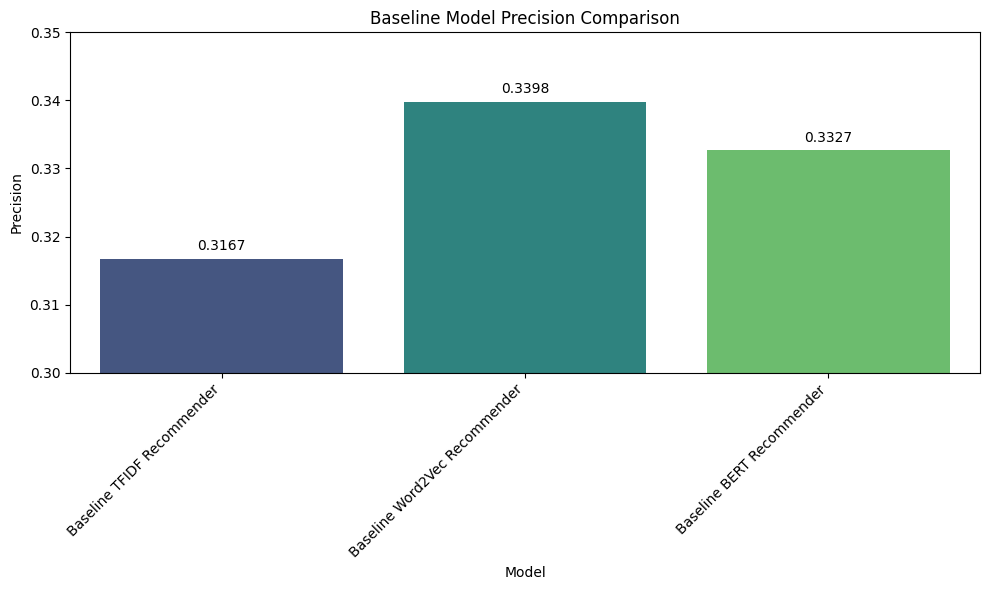

In [72]:
# Filter for baseline models
df_baseline_results = results_df[results_df['Model'].str.contains('Baseline')]

# Plot for Baseline Models
plt.figure(figsize=(10, 6))
baseline_plot = sns.barplot(x="Model", y="Precision", data=df_baseline_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Baseline Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.3, 0.35)  # Adjust the y-axis limit to start closer to the minimum precision value

# Annotate bars with precision values
for p in baseline_plot.patches:
    baseline_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 9),
                           textcoords = 'offset points')

plt.tight_layout()

# Display the plot
plt.show()

The Baseline TFIDF Recommender had a precision of 0.316743, with the Baseline Word2Vec Recommender scoring slightly higher at 0.339771. Both models employ cosine similarity on basic TFIDF and Word2Vec embeddings, respectively. Their relatively low precision scores indicate that, while they capture some relevance, there is plenty of room for improvement. The Baseline BERT Recommender, with a precision of 0.332673, outperforms the TFIDF baseline but is comparable to the Word2Vec baseline, demonstrating the fundamental level of relevance captured by the BERT embeddings alone. Among the baseline models, Word2Vec performed the best, highlighting its capability to capture semantic relationships in text.

### Advanced Models

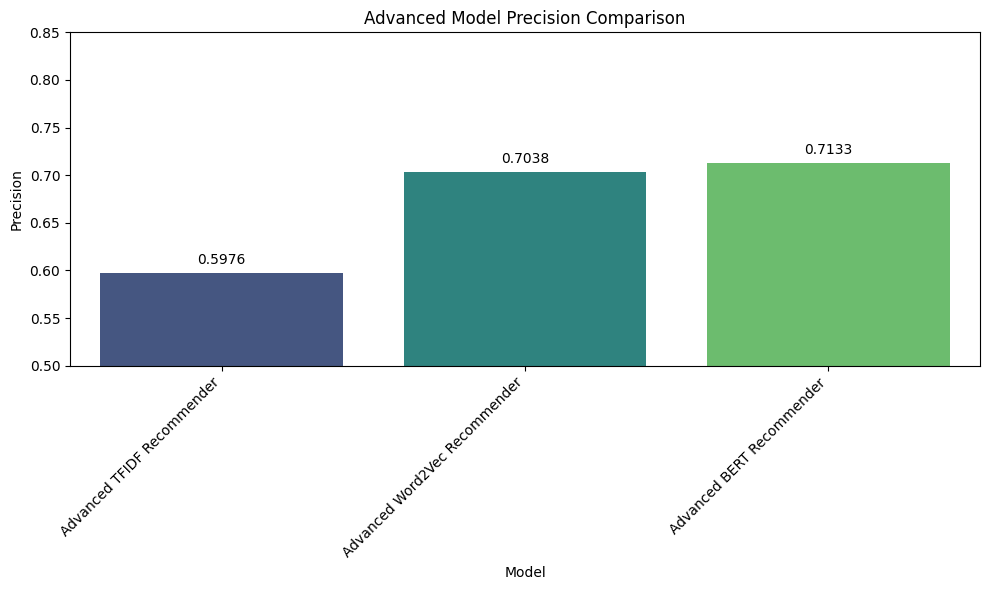

In [77]:
# Filter for advanced models only
df_advanced_results = results_df[results_df['Model'].str.contains('Advanced')]

# Plot for Advanced Models with Adjusted Scale and Annotations
plt.figure(figsize=(10, 6))
advanced_plot = sns.barplot(x="Model", y="Precision", data=df_advanced_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Advanced Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.5, 0.85)  # Adjust the y-axis limit to ensure all scores are visible

# Annotate bars with precision values
for p in advanced_plot.patches:
    advanced_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 9),
                           textcoords='offset points')

plt.tight_layout()

# Display the plot
plt.show()

#### Advanced Models
Incorporating additional features significantly improves precision across all advanced models. The Advanced TFIDF Recommender shows a notable increase in precision to 0.597629, indicating that the extra features add valuable information that enhances the relevance of the recommendations. The Advanced Word2Vec Recommender achieves a precision of 0.703803, demonstrating substantial improvement over its baseline counterpart. This improvement signifies that integrating additional features makes this model much more effective in providing relevant recommendations. The Advanced BERT Recommender, with a precision of 0.713317, achieves the highest precision among the purely advanced models. This suggests that BERT embeddings, combined with additional features, provide a very robust understanding of the content, leading to highly relevant recommendations. These results highlight the power of transfer learning, as the models leveraging pre-trained embeddings clearly outperformed the self-trained TFIDF approach in terms of precision.

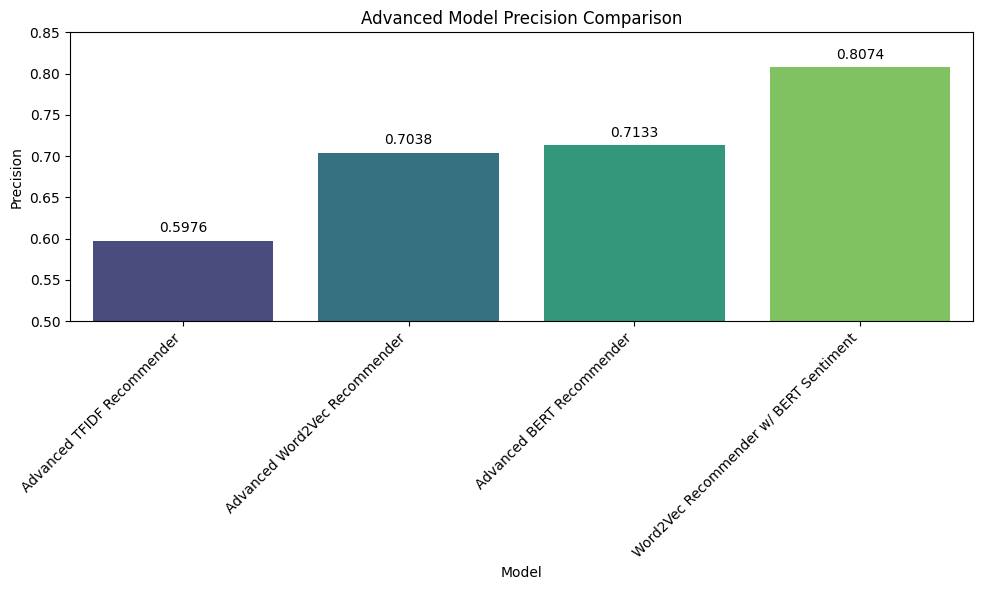

In [78]:
# Filter for advanced models including hybrid model
df_advanced_results = results_df[results_df['Model'].str.contains('Advanced') | results_df['Model'].str.contains('BERT Sentiment')]

# Plot for Advanced Models with Adjusted Scale and Annotations
plt.figure(figsize=(10, 6))
advanced_plot = sns.barplot(x="Model", y="Precision", data=df_advanced_results, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Advanced Model Precision Comparison")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.ylim(0.5, 0.85)  # Adjust the y-axis limit to ensure all scores are visible

# Annotate bars with precision values
for p in advanced_plot.patches:
    advanced_plot.annotate(format(p.get_height(), '.4f'),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           xytext=(0, 9),
                           textcoords='offset points')

plt.tight_layout()

# Display the plot
plt.show()

#### Hybrid Model
The Word2Vec baseline model performed best in terms of cosine similarity, so combining it with the powerful BERT sentiment analysis is very reasonable. The Word2Vec Recommender with BERT Sentiment has the highest precision score (0.807405), outperforming all other models, including the advanced BERT model. This hybrid approach, which combines Word2Vec embeddings with BERT-based sentiment analysis, demonstrates the value of combining the strengths of two models: Word2Vec for semantic relationships and BERT for nuanced sentiment analysis. As expected, the additional weight assigned to sentiment polarity is a highly influential feature, resulting in the most relevant and accurate recommendations.

#### Conclusion
The evaluation reveals that adding more features significantly improves the precision of recommendations across all models. When considering cosine similarity and additional features, the BERT-based approach outperforms the other advanced models. However, the hybrid model that combines Word2Vec embeddings with BERT sentiment analysis has the highest precision, indicating that a multifaceted approach that takes advantage of the various models' strengths can result in the most relevant and accurate content-based recommendations.